In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from pathlib import Path
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
data_dir = Path("/kaggle/input/brainmetshare-t1-gd/BrainMetShare_t1_gd")

### U-NET Model

- Consider adding batchnorm to doubleConv

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        return x


- consider adding other encoder layer

In [5]:
class UNETModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        # Down
        self.down1 = DoubleConv(in_channels,64)
        self.down2 = DoubleConv(64,128)
        self.down3 = DoubleConv(128,256)
        self.bottleneck = DoubleConv(256,512)

        self.pool = nn.MaxPool2d(2)

        # Up
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.right1 = DoubleConv(512, 256) # 256 (up) + 256 (encoder3)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.right2 = DoubleConv(256, 128) # 128 (up) + 128 (encoder2)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.right3 = DoubleConv(128, 64) # 64 (up) + 64 (encoder1)

        # Out
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Down
        encoder1 = self.down1(x)
        encoder2 = self.down2(self.pool(encoder1))
        encoder3 = self.down3(self.pool(encoder2))

        # Bottleneck
        bneck = self.bottleneck(self.pool(encoder3))

        # Up
        decoder1 = self.up1(bneck)
        decoder1 = self.right1(torch.cat([decoder1, encoder3], dim=1))
        decoder2 = self.up2(decoder1)
        decoder2 = self.right2(torch.cat([decoder2, encoder2], dim=1))
        decoder3 = self.up3(decoder2)
        decoder3 = self.right3(torch.cat([decoder3, encoder1], dim=1))

        # Out
        out = self.out(decoder3)
        return out


In [6]:
class DoubleConv3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        return x

In [7]:
class UNET3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.pool = nn.MaxPool3d(2)
        # Down
        self.down1 = DoubleConv3D(in_channels,32)
        self.down2 = DoubleConv3D(32,64)
        self.down3 = DoubleConv3D(64,128)

        #  Bottleneck
        self.bottleneck = DoubleConv3D(128,256)

        # Up
        self.up1 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.right1 = DoubleConv3D(256, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.right2 = DoubleConv3D(128, 64)
        self.up3 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.right3 = DoubleConv3D(64, 32)

        # Out
        self.out = nn.Conv3d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Down
        encoder1 = self.down1(x)
        encoder2 = self.down2(self.pool(encoder1))
        encoder3 = self.down3(self.pool(encoder2))

        # Bottleneck
        bneck = self.bottleneck(self.pool(encoder3))

        # Up
        decoder1 = self.up1(bneck)
        decoder1 = self.right1(torch.cat([decoder1, encoder3], dim=1))
        decoder2 = self.up2(decoder1)
        decoder2 = self.right2(torch.cat([decoder2, encoder2], dim=1))
        decoder3 = self.up3(decoder2)
        decoder3 = self.right3(torch.cat([decoder3, encoder1], dim=1))

        # Out
        out = self.out(decoder3)
        return out


### Preparing Data

In [8]:
def largest_slice(mask):
    slice_sums = mask.sum(axis=(0, 1))
    z = int(np.argmax(slice_sums))
    return z

In [9]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

class MRIDataset(Dataset):
    def __init__(self, dir_list):
        self.sample_dirs = dir_list  # Already a list of Path objects

    def __len__(self):
        return len(self.sample_dirs)

    def __getitem__(self, idx):
        sample_dir = self.sample_dirs[idx]
        image = np.load(sample_dir / "image.npy")
        mask = np.load(sample_dir / "mask.npy")

        # Conver to tensor
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        
        # Take slice
        z = largest_slice(mask)
        image = image[:,:,z].unsqueeze(0)
        #image = torch.stack([image[z,:,:],image[:,z,:],image[:,:,z]], dim=0)
        mask = mask[:,:,z].unsqueeze(0)

        

        return image, mask, sample_dir.name

In [10]:
from torch.utils.data import Dataset

class MRIDataset3D(Dataset):
    def __init__(self, dir_list, patch_size=(96, 96, 96), stride=(96, 96, 96)):
        self.patch_size = patch_size
        self.stride = stride
        self.sample_dirs = dir_list
        self.patch_indices = []  # list of (sample_idx, z, y, x)

        # Precompute all patch indices
        for sample_idx, sample_dir in enumerate(self.sample_dirs):
            image = np.load(sample_dir / "image.npy")  # assume shape (D, H, W)
            D, H, W = image.shape
            pd, ph, pw = patch_size
            sd, sh, sw = stride

            for z in range(0, max(1, D - pd + 1), sd):
                for y in range(0, max(1, H - ph + 1), sh):
                    for x in range(0, max(1, W - pw + 1), sw):
                        self.patch_indices.append((sample_idx, z, y, x))

    def __len__(self):
        return len(self.patch_indices)

    def __getitem__(self, idx):
        sample_idx, z, y, x = self.patch_indices[idx]
        sample_dir = self.sample_dirs[sample_idx]

        image = np.load(sample_dir / "image.npy")
        mask = np.load(sample_dir / "mask.npy")

        patch_img = image[z:z+self.patch_size[0], y:y+self.patch_size[1], x:x+self.patch_size[2]]
        patch_mask = mask[z:z+self.patch_size[0], y:y+self.patch_size[1], x:x+self.patch_size[2]]

        # Add channel dim and convert to torch
        patch_img = torch.tensor(patch_img, dtype=torch.float32).unsqueeze(0)
        patch_mask = torch.tensor(patch_mask, dtype=torch.float32).unsqueeze(0)

        return patch_img, patch_mask, sample_dir.name

In [11]:
from sklearn.model_selection import train_test_split

# Split data into train and test
dirs = sorted([p for p in data_dir.iterdir() if p.is_dir()])
train_dirs, test_dirs = train_test_split(dirs, test_size=0.2, random_state=12)
train_data = MRIDataset3D(train_dirs)
test_data = MRIDataset3D(test_dirs)

In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=2, shuffle=True)
test_loader = DataLoader(test_data, batch_size=2, shuffle=False)

In [13]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # Apply sigmoid to logits
        probs = torch.sigmoid(logits)
        targets = targets.float()

        intersection = (probs * targets).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()



In [14]:
def combined_loss(logits, targets):
    return DiceLoss()(logits, targets) + nn.BCEWithLogitsLoss()(logits, targets)

In [15]:
def safe_dice_loss(logits, targets, smooth=1e-6):
    probs = torch.sigmoid(logits)
    targets = targets.float()
    valid = targets.sum(dim=(2, 3)) > 0  # skip blank targets
    intersection = (probs * targets).sum(dim=(2, 3))
    union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice[valid].mean() if valid.any() else torch.tensor(0.0, device=logits.device)

In [17]:
model = UNET3D().to(device)
criterion = combined_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 30
train_losses = [0] * epochs
test_losses = [0] * epochs
for i in range(epochs):
    model.train()
    train_loss_total = 0
    for b, (img_train, mask_train, names) in enumerate(train_loader):
        img_train = img_train.to(device)
        mask_train = mask_train.to(device)

        mask_pred = model(img_train)
        loss = criterion(mask_pred, mask_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_total += loss.item()
        print(f'  Batch: {b+1} Loss: {loss.item()}')

    train_losses[i] = train_loss_total / len(train_loader)
    print(f'Epoch: {i+1} Loss: {train_loss_total / len(train_loader)}')

    # testing
    model.eval()
    test_loss_total = 0
    with torch.no_grad():
        for b, (img_test, mask_test, names) in enumerate(test_loader):
            img_test = img_test.to(device)
            mask_test = mask_test.to(device)

            mask_pred = model(img_test)
            loss = criterion(mask_pred, mask_test)
            test_loss_total += loss.item()

    test_losses[i] = test_loss_total / len(test_loader)

  Batch: 1 Loss: 1.8306078910827637
  Batch: 2 Loss: 1.805379867553711
  Batch: 3 Loss: 1.8331947326660156
  Batch: 4 Loss: 1.7702512741088867
  Batch: 5 Loss: 1.7654271125793457
  Batch: 6 Loss: 1.8454076051712036
  Batch: 7 Loss: 1.8151237964630127
  Batch: 8 Loss: 1.7543878555297852
  Batch: 9 Loss: 1.7673753499984741
  Batch: 10 Loss: 1.7393085956573486
  Batch: 11 Loss: 1.7362914085388184
  Batch: 12 Loss: 1.7301521301269531
  Batch: 13 Loss: 1.7241778373718262
  Batch: 14 Loss: 1.7145717144012451
  Batch: 15 Loss: 1.7050930261611938
  Batch: 16 Loss: 1.6970632076263428
  Batch: 17 Loss: 1.7423415184020996
  Batch: 18 Loss: 1.718427062034607
  Batch: 19 Loss: 1.7028329372406006
  Batch: 20 Loss: 1.7444605827331543
  Batch: 21 Loss: 1.6775184869766235
  Batch: 22 Loss: 1.673449158668518
  Batch: 23 Loss: 1.701025366783142
  Batch: 24 Loss: 1.6849285364151
  Batch: 25 Loss: 1.717123031616211
  Batch: 26 Loss: 1.6441752910614014
  Batch: 27 Loss: 1.69108247756958
  Batch: 28 Loss: 1.

KeyboardInterrupt: 

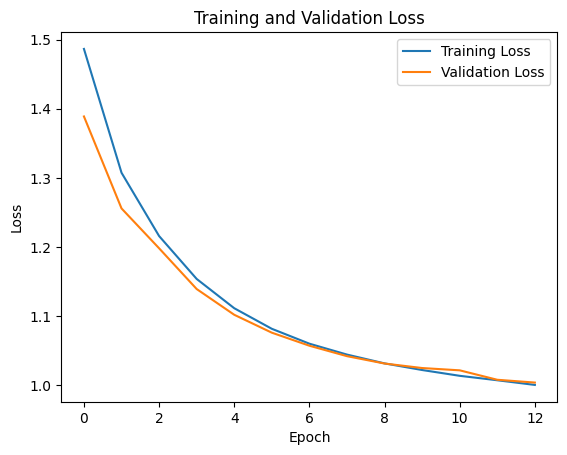

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(13), train_losses[:13], label='Training Loss')
plt.plot(range(13), test_losses[:13], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [24]:
def iou_score(preds, targets, threshold=0.5, eps=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    intersection = (preds * targets).sum(dim=(2, 3))
    union = ((preds + targets) > 0).float().sum(dim=(2, 3))

    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()


In [25]:
def dice_score(preds, targets, threshold=0.5, eps=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    intersection = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))

    dice = (2 * intersection + eps) / (union + eps)
    return dice.mean().item()


In [26]:
model.eval()
with torch.no_grad():
    iou_total = 0
    dice_total = 0
    for img_batch, mask_batch, _ in test_loader:
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)

        preds = model(img_batch)

        iou_total += iou_score(preds, mask_batch)
        dice_total += dice_score(preds, mask_batch)

    print("Mean IoU:", iou_total / len(test_loader))
    print("Mean Dice Score:", dice_total / len(test_loader))

Mean IoU: 0.8579969097461019
Mean Dice Score: 0.8624589102608817


In [30]:
# Save model weights
torch.save(model.state_dict(), "/kaggle/working/unet3d_model.pth")

In [32]:
def sliding_window_inference(volume, model, patch_size=(128, 128, 128), stride=(64, 64, 64)):
    model.eval()
    device = next(model.parameters()).device
    
    D, H, W = volume.shape
    C = 1  # assuming single-channel output

    output = np.zeros((C, D, H, W), dtype=np.float32)
    count_map = np.zeros((C, D, H, W), dtype=np.float32)

    with torch.no_grad():
        for z in range(0, D - patch_size[0] + 1, stride[0]):
            for y in range(0, H - patch_size[1] + 1, stride[1]):
                for x in range(0, W - patch_size[2] + 1, stride[2]):
                    patch = volume[z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]]

                    # normalize patch
                    patch = (patch - patch.mean()) / (patch.std() + 1e-8)

                    # predict
                    input_tensor = torch.tensor(patch, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
                    pred = model(input_tensor)  # shape: [1, 1, D, H, W]
                    pred = torch.sigmoid(pred).cpu().numpy()[0]

                    output[:, z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]] += pred
                    count_map[:, z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]] += 1

    # Avoid divide-by-zero
    count_map[count_map == 0] = 1
    averaged_output = output / count_map
    return averaged_output.squeeze()  # final prediction shape: (D, H, W)

In [33]:
def evaluate_full_images(sample_dirs, model, threshold=0.5):
    model.eval()
    for sample_dir in sample_dirs:
        image = np.load(sample_dir / "image.npy")  # (D, H, W)
        mask = np.load(sample_dir / "mask.npy")    # (D, H, W)

        # Normalize image
        image_norm = (image - image.mean()) / (image.std() + 1e-8)

        # Run patch-wise inference on full volume
        pred = sliding_window_inference(image_norm, model, patch_size=(96, 96, 96), stride=(48, 48, 48))
        pred = (pred > threshold).astype(float)

        # Prepare for plotting
        image_tensor = torch.tensor(image_norm).unsqueeze(0)  # [1, D, H, W]
        mask_tensor = torch.tensor(mask).unsqueeze(0)
        pred_tensor = torch.tensor(pred).unsqueeze(0)

        plot_predictions_grid(
            images=image_tensor.unsqueeze(0),    # [B, 1, D, H, W]
            masks=mask_tensor.unsqueeze(0),
            model=None,  # Not needed now
            names=[sample_dir.name],
            threshold=threshold
        )

In [34]:
evaluate_full_images(test_dirs, model)

NameError: name 'plot_predictions_grid' is not defined